# Configuration section

У цій секкціх ми під'єднуємось до гугл диску, щоб мати постійне сховище даних. Такожвиконуємо необхідні імпорти та виставляємо значення сіду, що дозволить відтворити результати блокноту.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import copy
import torch
import torch.optim as optim
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

In [6]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

In [7]:
set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/CV_lab5/"

Random seed set as 42


In [5]:
# !unrar x "/content/drive/MyDrive/ColabData/CV_lab5/lgg-segmentation-data.rar" "/content/drive/MyDrive/ColabData/CV_lab5/"

https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?datasetId=181273&sortBy=voteCount&searchQuery=pytorch

# Load and prepare data

Даний датасет містить 3929 зображень сканів мозку. Ничже наведений код для завантаження, обробки та візуалізації одного батчу із датасету для демонстрації.

In [9]:
class Brain_data(Dataset):
    def __init__(self, path, img_transforms=None, mask_transform=None):
        self.path = path
        self.patients = [file for file in os.listdir(path) if file not in ['data.csv','README.md']]
        self.masks, self.images = [], []

        for patient in self.patients:
            for file in os.listdir(os.path.join(self.path,patient)):
                if 'mask' in file.split('.')[0].split('_'):
                    self.masks.append(os.path.join(self.path, patient,file))
                else: 
                    self.images.append(os.path.join(self.path, patient,file)) 
          
        self.images = sorted(self.images)
        self.masks = sorted(self.masks)
        self.img_transforms = img_transforms
        self.mask_transform = mask_transform

        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        mask = self.masks[idx]
        image = Image.open(image)     
        mask = Image.open(mask)

        if self.img_transforms:
            image = self.img_transforms(np.array(image))
        if self.mask_transform:
            mask = self.mask_transform(np.array(mask))
        
        return (image, mask)

In [10]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((256, 256)),
])

In [12]:
dataset = Brain_data(folder_path + "lgg-segmentation-data", image_transform, mask_transform)

In [13]:
train_set_size = int(len(dataset) * 0.8)
valid_set_size = len(dataset) - train_set_size

image_datasets = {}
image_datasets['train'], image_datasets['val'] = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size])

In [14]:
def create_dataloaders(image_datasets, batch_size=64):
    return {x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size,
        shuffle=True, 
    ) for x in image_datasets.keys()}

In [15]:
dataloaders = create_dataloaders(image_datasets)

In [16]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
dataset_sizes

{'train': 3143, 'val': 786}

In [17]:
def imshow(inp, denorm=True):
    inp = inp.numpy().transpose((1, 2, 0))
    if denorm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

Нижче наведено 64 зображення зі сканами мозку та 64 відповідних маски, де помічено розташування пухлини.

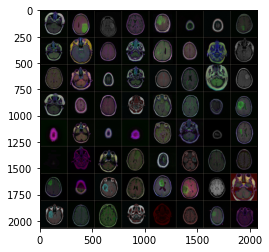

In [18]:
inputs, masks = next(iter(dataloaders['train']))
inputs_grid = torchvision.utils.make_grid(inputs)
imshow(inputs_grid)

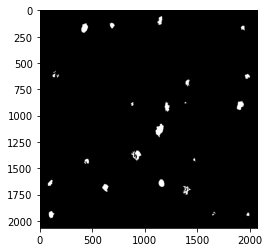

In [19]:
masks_grid = torchvision.utils.make_grid(masks)
imshow(masks_grid, False)

# Loading U-NET

У даній лабораторній роботі було використано претреновану модель U-NET, для зменшення часу тренування та простоти подальшох реалізації. Модель була тренована на сканах мозку, тому показала хороші рещзультати сегментації.

In [20]:
UNET_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
UNET_model.to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Training U-NET model

In [21]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    y_loss = {'train': [], 'val': []}

    best_loss = 1000

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0

                for inputs, target in dataloaders[phase]:
                    inputs = inputs.to(device)
                    target = target.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, target)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)

                epoch_loss = running_loss / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f}')

                y_loss[phase].append(epoch_loss)

                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                  
    model.load_state_dict(best_model_wts)
    return model, y_loss

In [22]:
def draw_graphs(y_loss, phases, num_epochs=10):
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    x_epochs = [i + 1 for i in range(num_epochs)]

    for phase in phases:
        ax0.plot(x_epochs, y_loss[phase], label=phase)
    
    ax0.legend()

    plt.show()

Програмна реалізації функції втрат, що використовується для тренування моделі. Функція базується на критерії Дайса, що показує подібність між двома елементами вибірки. По факту він обчислює співвідношення області перетину множин до суми їх областей.

In [23]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [24]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(UNET_model.parameters(), lr=0.01)

In [25]:
UNet_model, y_loss = train_model(UNET_model, criterion, optimizer, dataloaders, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.7274
val Loss: 0.6648
Epoch 2/5
----------
train Loss: 0.6537
val Loss: 0.6527
Epoch 3/5
----------
train Loss: 0.5546
val Loss: 0.8687
Epoch 4/5
----------
train Loss: 0.5129
val Loss: 0.5047
Epoch 5/5
----------
train Loss: 0.4754
val Loss: 0.4621


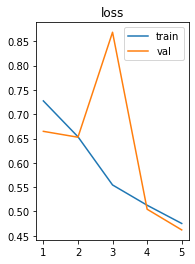

In [26]:
draw_graphs(y_loss, y_loss.keys(), num_epochs=5)

In [27]:
def convert_image_np(inp, denorm=True):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    if denorm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [28]:
inputs, masks = next(iter(dataloaders['train']))
predictions = UNET_model(inputs.to(device))

In [29]:
input_grid = convert_image_np(torchvision.utils.make_grid(inputs))
mask_grid = convert_image_np(torchvision.utils.make_grid(masks), False)
predictions_grid = convert_image_np(torchvision.utils.make_grid(predictions), False)

Нижче наведено результати сегментації зображень виконані нашою нейронною мережею. Ми бачимо, що на отриманих зображеннях є багато "зайвих" обастей, але загалом результати непогані. На мою думку так сталось через великий learning rate у оптимізаторі.

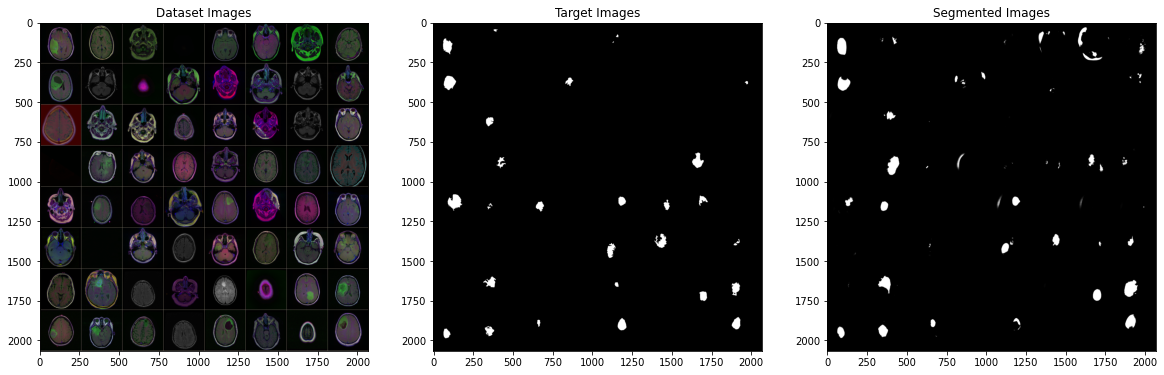

In [30]:
f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(input_grid)
ax[0].set_title('Dataset Images')

ax[1].imshow(mask_grid)
ax[1].set_title('Target Images')

ax[2].imshow(predictions_grid)
ax[2].set_title('Segmented Images')

plt.ioff()
plt.show()

Контрольнi запитання

1. Яка особливiсть задачi сегментацiї у порiвняннi з задачею класифiка-
цiї та регресiї?
У випадку задачі регресії ми намагаємось визначити числове значення.
У випадку класифікації належність до того чи іншого класу.
У випадку сегментації ми шукаємо області на зображенні, які підпадають під певний клас, та пікселі в яких є подібними.
2. Який принцип роботи архiтектури Encoder-Decoder?
Encoder частина мережі кодує вхідні дані, по факту відбувається downsampling. На основі отриманого кодування Decoder генерує відповідний прогноз, upsampling даних назад. Таким чином кодуючи дані виділяються деякі семантичні ознаки, на основі яких відбувається прогноз під час декодування.
3. Яка архiтектура моделi U-Net?
U-Net використову є симетричною архітектурою, яку можна поділити на 2 частини: ліву(кодувальник) та праву(декодувальник). Між цими двома частинами є зв'язки, деякі із яких перестрибують інші шари мережі(long skip-connections). Це дозволяє мережі зберігати високорівневі ознаки із перших шарів мережі, які потім використовуються під час формування виходу мережі. 
4. Якi loss-функцiї ви застосовували при навчаннi моделi?
У даній роботі використовувалась функція втрат на основі критерія Дайса, який показує подібність двох зображень.